<a href="https://colab.research.google.com/github/gabrielfernandezf/cautious-octo-waffle/blob/master/Challenge_Fair_Play.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FAIR PLAY CHALLENGE - DATA ANALYSIS**

**Qué impacto tiene el otorgamiento de préstamos en las ventas de nuestros clientes? **

Un primer y rápido análisis que podemos hacer es visualizar la evolución temporal de las ventas para cada cliente, identificando el momento del tiempo en el que se da el otorgamiento del préstamos, y a partir ahí, revisar que tendencia toman las ventas. En este sentido, podemos verificar una a una la evolución de ventas de cada uno de nuestros clientes.

Además, nos interesa revisar de manera general (para el conjunto de clientes) el cambio en dichas ventas, a partir del otorgamiento. Por esto, calculamos la variación porcentual desde el umbral de tiempo en el que se cuenta con los fondos de Fair Play en adelante.

En un primer momento, y con los datos disponibles, podemos concluir que en general, cada vez que FAIR PLAY ha otorgado un préstamo las ventas de sus clientes han aumentado.

----------------------------------------------------------------
-----------------------------------------------------------------
**What impact does the granting of loans have on our clients' sales?**

A first and quick analysis we can make is to visualize the temporal evolution of sales for each client, identifying the moment in time when the loan is granted, and from there, review the sales trend. In this sense, we can verify one by one the evolution of sales for each of our clients.

In addition, we are interested in reviewing in general (for the set of clients) the change in these sales, from the granting of the loan. For this reason, we calculate the percentage variation from the time threshold at which the Fair Play funds are available onwards.

Initially, and with the available data, we can conclude that in general, each time FAIR PLAY has granted a loan, its clients' sales have increased.

#IMPORT LIBRARIES AND DATA

In [372]:
import numpy as np
import pandas as pd 
import datetime

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

import warnings
warnings.filterwarnings('ignore')

In [373]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [374]:
sales = pd.read_csv('/content/drive/My Drive/sales.csv', index_col= 0)
contracts = pd.read_csv('/content/drive/My Drive/contracts.csv', index_col = 0)

In [375]:
contracts.rename(columns = {'company_id':'client_id'}, inplace = True)

In [377]:
sales.shape

(14098, 3)

In [378]:
contracts.shape

(20, 3)

In [379]:
df = pd.merge(sales, contracts, on = 'client_id')

In [380]:
df["date"] = df['date'].apply(pd.to_datetime)

df['month'] = pd.DatetimeIndex(df['date']).month
df['year'] = pd.DatetimeIndex(df['date']).year

In [381]:
df.isna().any(axis=0)

date             False
sales            False
client_id        False
approval_date    False
id               False
month            False
year             False
dtype: bool

#SELECTING CLIENT ID FOR TIME LINE - INDIVIDUAL RESULT

In [382]:
#Select customer and approval date to reference in the timeline chart (Sales evolution)

clients = df['client_id'].unique()
select_client = clients[0]

df_line = df[df['client_id'] == select_client]

app_date = pd.to_datetime(df_line['approval_date'].unique()) + pd.offsets.MonthEnd(0)

In [383]:
#Format of date columns
df_line['date'] = pd.to_datetime(df_line['date'])
df_line = df_line.set_index('date') 

monthly_summary = df_line.sales.resample('M').sum().to_frame().reset_index(level=0)

monthly_summary['pct_change'] = monthly_summary['sales'].pct_change().fillna(0)

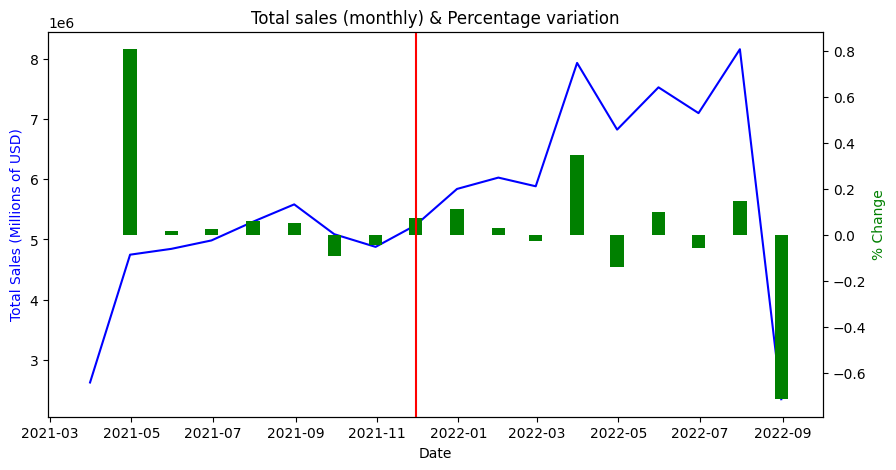

In [384]:
#Sales evolution and percentage changes in sales By Client_ID
#We visualize the approval date to identify changes in sales trend

fig, ax1 = plt.subplots(figsize = (10,5))

ax2 = ax1.twinx()
ax2.bar(monthly_summary['date'], monthly_summary['pct_change'], color='g', width = 10)
ax1.plot(monthly_summary['date'], monthly_summary['sales'], color='b')

ax1.set_xlabel('Date')
ax1.set_ylabel('Total Sales (Millions of USD)', color='b')
ax1.title.set_text('Total sales (monthly) & Percentage variation')
ax2.set_ylabel('% Change', color='g')



plt.axvline(app_date,color='r')
fig.show()


#OVERALL CHANGE AFTER LOANS 

In [385]:
#Datetime format for date column and approval date (loan)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

df['approval_end_date'] = pd.to_datetime(df.approval_date) + pd.offsets.MonthEnd(0)

df = df.reset_index()

#Slicing time series - Data after approved loans
df = df[df["date"] >= df.approval_end_date]

#Calculate monthly sales and normalize dates
df = df.set_index('date')
monthly = df.groupby([pd.Grouper(freq='M'), 'client_id'])
result = monthly['sales'].sum().unstack('client_id').fillna(1)

#Calculate Percentual change in sales, between first and last valid date
cols = result.columns.to_list()
cols
change = 100*(result[cols].iloc[-1]/result[cols].iloc[0]-1)

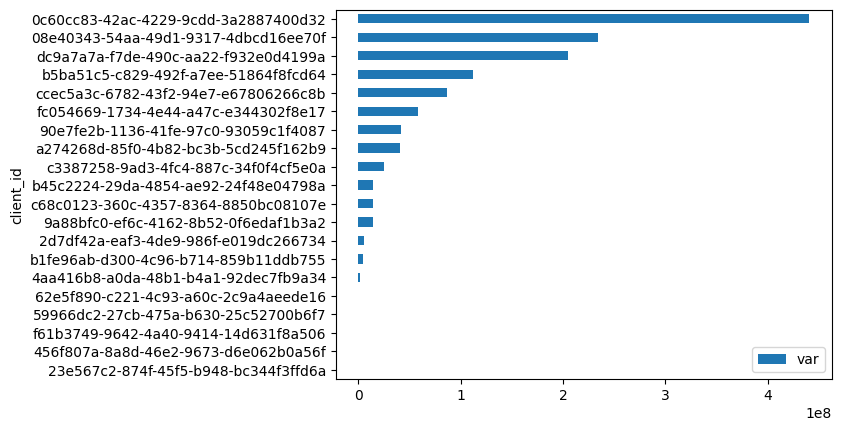

In [401]:
#Dataframe for bar chart with percentage change data
change = pd.DataFrame({'client_id':change.index, 'var':change.values})


#BAR CHART
df = change
sd = df.nlargest(20,'var')
fd = sd.sort_values(by='var', ascending = True)

ax = fd.plot.barh(x='client_id', y='var')
plt.show()